# Import all the modules and the function

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py
from keras import backend as K
import quandl

Using TensorFlow backend.


# Input of the Model

1. seq_len is the window frame of the past data.
2. Parameters to avoid overfitting:
   dropout - Dropout Fraction
   decay - Decay Weight Regularisation
   epochs - The number of epochs the is required to fit into the model
   shape - The amount of features will depend on how many moving average would we like to include

In [2]:
quandl.ApiConfig.api_key = 'yixxqRuSz4xs73E34iv2'
seq_len = 22
shape = [seq_len, 5, 1]
neurons = [256, 256, 32, 1]
dropout = 0.3
decay = 0.5
epochs = 100
crudeoil = "EIA/PET_RWTC_D"

# Get WTI Crude Oil price from the US Department of Energy

1. This uses Quandl and the API key can be obtained from https://www.quandl.com/product/WIKIP/WIKI/PRICES-Quandl-End-Of-Day-Stocks-Info Please login to use your key if you have one.\
2. Get WTI crude oil price in time series format for a given quandl code: EIA/PET_RWTC_D => WTI Crude Oil Price from US DoE
3. Moving average can be included by simply putting the number of days in the list.These will be included in the neural network model.

In [3]:
def get_crude_oil_timeseries_data(qaundl_code, normalise=True, ma=[]):
    df = quandl.get(qaundl_code, returns="raw")
    df['Pct'] = df['Value'].pct_change()
    df = df.rename(columns={'Value': 'Price'})
    
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['Price'].rolling(window=moving).mean()
    df.dropna(inplace=True)
    
    if normalise:
        min_max_scaler = preprocessing.MinMaxScaler()
        df['Price'] = min_max_scaler.fit_transform(df.Price.values.reshape(-1,1))
        df['Pct'] = min_max_scaler.fit_transform(df['Pct'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df['{}ma'.format(moving)] = min_max_scaler.fit_transform(df['{}ma'.format(moving)].values.reshape(-1,1))  
                    
    
    # Move Adj Close to the rightmost for the ease of training
    price = df['Price']
    df.drop(labels=['Price'], axis=1, inplace=True)
    df = pd.concat([df, price], axis=1)
    
    return df



In [4]:
moving_avg = [50, 100, 200]
crudeoil_df = get_crude_oil_timeseries_data(crudeoil, ma=moving_avg)

# Visualise Data

Print out the first few rows of the dataframe and plot the price and the percentage change of the crude oil.

In [5]:
def plot_prices(df):
    print(df.head())
    plt.subplot(211)
    plt.plot(df['Price'], color='red', label='Oil Prices')
    plt.legend(loc='best')
    plt.subplot(212)
    plt.plot(df['Pct'], color='blue', label='Percentage change')
    plt.legend(loc='best')
        
    plt.show()

                 Pct      50ma     100ma     200ma     Price
Date                                                        
1986-10-16  0.579250  0.026504  0.012182  0.015846  0.027586
1986-10-17  0.657264  0.026512  0.012160  0.015305  0.029965
1986-10-20  0.656388  0.026511  0.012206  0.014759  0.032344
1986-10-21  0.622687  0.026575  0.012269  0.014189  0.032716
1986-10-22  0.571716  0.026563  0.012318  0.013634  0.029965


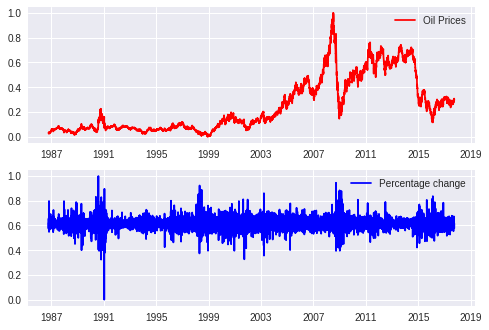

In [6]:
plot_prices(crudeoil_df)

# Split out training set and testing set data

In [7]:
def load_data(crudeoil, seq_len):
    amount_of_features = len(crudeoil.columns)
    print ("Amount of features = {}".format(amount_of_features))
    data = crudeoil.as_matrix()
    sequence_length = seq_len + 1 # index starting from 0
    result = []

    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days

    result = np.array(result)
    row = round(0.8 * result.shape[0]) # 80% split
    print ("Amount of training data = {}".format(0.9 * result.shape[0]))
    print ("Amount of testing data = {}".format(0.1 * result.shape[0]))

    train = result[:int(row), :] # 90% date
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price

    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))

    return [X_train, y_train, X_test, y_test]

In [8]:
X_train, y_train, X_test, y_test = load_data(crudeoil_df, seq_len)

Amount of features = 5
Amount of training data = 7017.3
Amount of testing data = 779.7


# Model Execution

In [9]:
def build_model(shape, neurons, dropout, decay):
    model = Sequential()

    model.add(LSTM(neurons[0], input_shape=(shape[0], shape[1]), return_sequences=True))
    model.add(Dropout(dropout))

    model.add(LSTM(neurons[1], input_shape=(shape[0], shape[1]), return_sequences=False))
    model.add(Dropout(dropout))

    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))

    adam = keras.optimizers.Adam(decay=decay)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [10]:
model = build_model(shape, neurons, dropout, decay)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 22, 256)           268288    
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 801,857
Trainable params: 801,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.2,
    verbose=1)

Train on 4990 samples, validate on 1248 samples
Epoch 1/100
4990/4990 [==============================] - 20s - loss: 0.0098 - acc: 2.0040e-04 - val_loss: 0.0185 - val_acc: 8.0128e-04
Epoch 2/100
4990/4990 [==============================] - 19s - loss: 0.0011 - acc: 2.0040e-04 - val_loss: 0.0215 - val_acc: 8.0128e-04
Epoch 3/100
4990/4990 [==============================] - 20s - loss: 7.0564e-04 - acc: 2.0040e-04 - val_loss: 0.0171 - val_acc: 8.0128e-04
Epoch 4/100
4990/4990 [==============================] - 21s - loss: 5.5846e-04 - acc: 2.0040e-04 - val_loss: 0.0210 - val_acc: 8.0128e-04
Epoch 5/100
4990/4990 [==============================] - 23s - loss: 5.0824e-04 - acc: 2.0040e-04 - val_loss: 0.0170 - val_acc: 8.0128e-04
Epoch 6/100
4990/4990 [==============================] - 25s - loss: 4.3533e-04 - acc: 2.0040e-04 - val_loss: 0.0172 - val_acc: 8.0128e-04
Epoch 7/100
4990/4990 [==============================] - 26s - loss: 4.0344e-04 - acc: 2.0040e-04 - val_loss: 0.0148 - val_acc

Save the LSTM trained model. Very effective against Jupyter Notebook timeouts!

In [13]:
model.save('LSTM_CrudeOil_Prediction-20171008.h5')

# Result on Training and Testing Sets

In [11]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [12]:
model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00036 MSE (0.02 RMSE)
Test Score: 0.00044 MSE (0.02 RMSE)


(0.00035610242470512606, 0.00043744767741038065)

# Prediction vs Real Results

In [13]:
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]

    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u

        percentage_diff.append((pr-y_test[u]/pr)*100)
    return p

In [14]:
p = percentage_difference(model, X_test, y_test)

In [15]:
def denormalise(crude_oil, normalised_value):
    """
    Return a dataframe of that crude oil and normalize all the values. 
    (Optional: create moving average)
    """
    df = quandl.get(crude_oil, returns="raw")
    df = df.rename(columns={'Value': 'Price'})    
    df['Pct'] = df['Price'].pct_change()
    df.dropna(inplace=True)
    
    df = df['Price'].values.reshape(-1,1)
    normalised_value = normalised_value.reshape(-1,1)

    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalised_value)
      
    return new

In [16]:
def plot_result(crude_oil, normalised_value_p, normalised_value_y_test):
    newp = denormalise(crude_oil, normalised_value_p)
    newy_test = denormalise(crude_oil, normalised_value_y_test)
    plt2.plot(newp, color='red', label='Prediction')
    plt2.plot(newy_test,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format(crude_oil))
    plt2.xlabel('Days')
    plt2.ylabel('Oil Price')
    plt2.show()

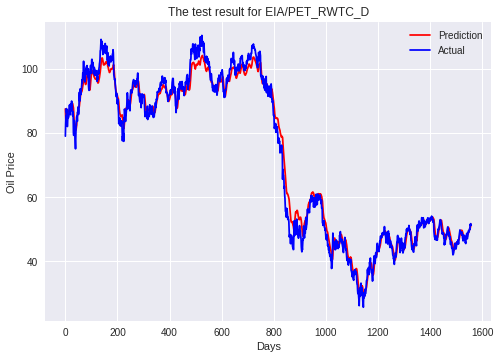

In [17]:
plot_result(crudeoil, p, y_test)

# Finding the best hyperparameter

In [21]:
def quick_measure(crude_oil, seq_len, dropout, shape, neurons, epochs, decay):
    moving_avg = [50, 100, 200]
    df = get_crude_oil_timeseries_data(crude_oil, ma=moving_avg)
    X_train, y_train, X_test, y_test = load_data(df, seq_len)
    model = build_model(shape, neurons, dropout, decay)
    model.fit(X_train, y_train, batch_size=512, epochs=epochs, validation_split=0.2, verbose=0)
    # model.save('LSTM_CrudeOil_Prediction-20171008.h5')
    trainScore, testScore = model_score(model, X_train, y_train, X_test, y_test)
    return trainScore, testScore

## Testing for epochs

Repeatedly test it and sum it up

In [22]:
epochslist = [20, 40, 60, 80, 100]
epochs_train_result = {}
epochs_test_result = {}

for epoch in epochslist:    
    trainScore, testScore = quick_measure(crudeoil, seq_len, dropout, shape, neurons, epoch, decay)
    epochs_train_result[epoch] = trainScore
    epochs_test_result[epoch] = testScore

Amount of features = 5
Amount of training data = 7017.3
Amount of testing data = 779.7
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 22, 256)           268288    
_________________________________________________________________
dropout_3 (Dropout)          (None, 22, 256)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 801,857
Trainable params: 801,857
Non-tra

In [23]:
min_test_val = min(epochs_test_result.values())
min_test_val_key = [k for k, v in epochs_test_result.items() if v == min_test_val]
print (epochs_test_result)
print (min_test_val_key)

{40: 0.001190276304920753, 60: 0.00088329363457208612, 20: 0.0035865982317283118, 80: 0.00058416286021274039, 100: 0.00037985751733546472}
[100]


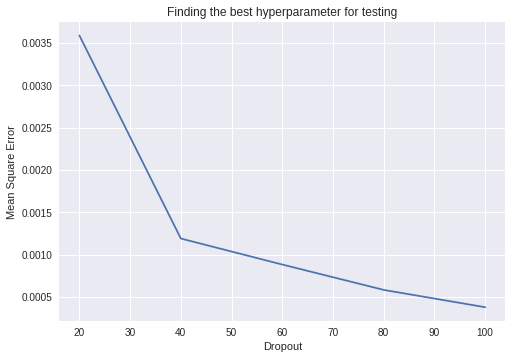

In [24]:
lists1 = sorted(epochs_test_result.items())
x1,y1 = zip(*lists1)
plt.plot(x1,y1)

plt.title('Finding the best hyperparameter for testing')
plt.xlabel('Dropout')
plt.ylabel('Mean Square Error')
plt.show()

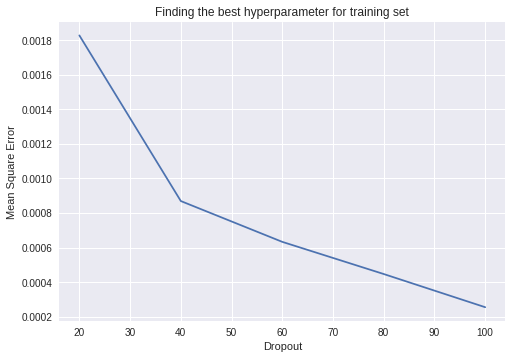

In [26]:
lists2 = sorted(epochs_train_result.items())
x2,y2 = zip(*lists2)
plt.plot(x2,y2)
plt.title('Finding the best hyperparameter for training set')
plt.xlabel('Dropout')
plt.ylabel('Mean Square Error')
plt.show()

## Testing for Dropouts

In [27]:
dlist = [0.1, 0.2, 0.3, 0.5, 0.7]
dropout_train_result = {}
dropout_test_result = {}

for d in dlist:    
    trainScore, testScore = quick_measure(crudeoil, seq_len, d, shape, neurons, epochs, decay)
    dropout_train_result[d] = trainScore
    dropout_test_result[d] = testScore

Amount of features = 5
Amount of training data = 7017.3
Amount of testing data = 779.7
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 22, 256)           268288    
_________________________________________________________________
dropout_13 (Dropout)         (None, 22, 256)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 801,857
Trainable params: 801,857
Non-tra

In [28]:
min_train_val = min(dropout_train_result.values())
min_train_val_key = [k for k, v in dropout_train_result.items() if v == min_train_val]
print (dropout_train_result)
print (min_train_val_key)

{0.1: 0.00063246040161760717, 0.2: 0.0010434630370951034, 0.3: 0.00092543684954670433, 0.7: 0.00088025707973854971, 0.5: 0.00093968074106587872}
[0.1]


In [29]:
min_test_val = min(dropout_test_result.values())
min_test_val_key = [k for k, v in dropout_test_result.items() if v == min_test_val]
print (dropout_test_result)
print (min_test_val_key)

{0.1: 0.00083108207702265889, 0.2: 0.0014722656336600454, 0.3: 0.0012222320886611901, 0.7: 0.0012791534278522687, 0.5: 0.0014727705986622985}
[0.1]


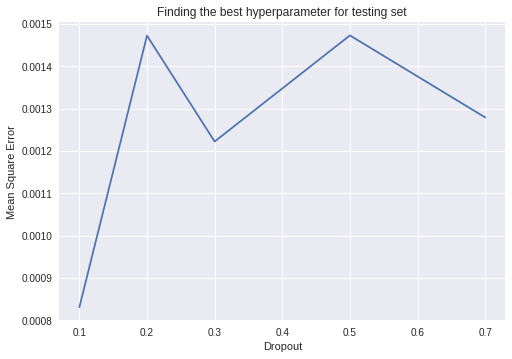

In [ ]:
lists1 = sorted(dropout_test_result.items())
x1,y1 = zip(*lists1)
plt.plot(x1,y1)
plt.title('Finding the best hyperparameter for testing set')
plt.xlabel('Dropout')
plt.ylabel('Mean Square Error')
plt.show()

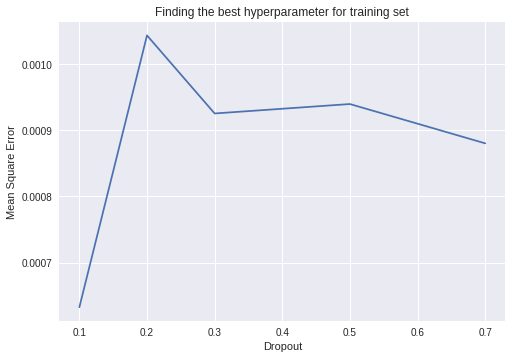

In [32]:
lists2 = sorted(dropout_train_result.items())
x2,y2 = zip(*lists2)
plt.plot(x2,y2)
plt.title('Finding the best hyperparameter for training set')
plt.xlabel('Dropout')
plt.ylabel('Mean Square Error')
plt.show()